# Conformalized Quantile Regression

## Theoretic Foundation

Conformalized Quantile Regression (CQR) is a post-hoc uncertainty quantification method to yield calibrated predictive uncertainty bands with proven coverage guarantees [Angelopoulos, 2021](https://people.eecs.berkeley.edu/~angelopoulos/publications/downloads/gentle_intro_conformal_dfuq.pdf). Based on a held out calibration set, CQR uses a score function to find a desired coverage quantile $\hat{q}$ and conformalizes the QR output by adjusting the quantile bands via $\hat{q}$ for an unseen test point as follows $x_{\star}$:

$$
    T(x_{\star})=[\hat{y}_{\alpha/2}(x_{\star})-\hat{q}, \hat{y}_{1-\alpha/2}(x_{\star})+\hat{q}]
$$

where $\hat{y}_{\alpha/2}(x_{\star})$ is the lower quantile output and $\hat{y}_{1-\alpha/2}(x_{\star})$, [Romano, 2019](https://proceedings.neurips.cc/paper_files/paper/2019/file/5103c3584b063c431bd1268e9b5e76fb-Paper.pdf).

**_NOTE:_** In the current setup we follow the Conformal Prediction Tutorial linked below, where they apply Conformal Prediction to Quantile Regression. However, Conformal Prediction is a more general statistical framework and model-agnostic in the sense that whatever Frequentist or Bayesian approach one might take, Conformal Prediction can be applied to calibrate your predictive uncertainty bands.

Conformalize the quantile regression model. From Chapter 2.2 of [Angelopoulos, 2021](https://people.eecs.berkeley.edu/~angelopoulos/publications/downloads/gentle_intro_conformal_dfuq.pdf). 

1. Identify a heuristic notion of uncertainty for our problem and use it to construct a scoring function, where large scores imply a worse fit between inputs $X$ and scalar output $y$. In the regression case, it is recommended to use a quantile loss that is then adjusted for prediction time via the conformal prediction method. 
2. Compute the Score function output for all data points in your held out validation set and compute a desired quantile $\hat{q}$ across those scores.
3. Conformalize your quantile regression bands with the computed $\hat{q}$. The prediction set for an unseen test point $x_{\star}$ is now $T(x_{\star})=[\hat{y}_{\alpha/2}(x_{\star})-\hat{q}, \hat{y}_{1-\alpha/2}(x_{\star})+\hat{q}]$ where $\hat{y}_{\alpha/2}(x_{\star})$ is the lower quantile model output and $\hat{y}_{1-\alpha/2}(x_{\star})$ is the upper quantile model output. This means we are adjusting the quantile bands symmetrically on either side and this conformalized prediction interval is guaranteed to satisfy our desired coverage requirement regardless of model choice.

The central assumption conformal prediction makes is exchangeability, which restricts us in the following two ways [Barber, 2022](https://arxiv.org/abs/2202.13415):
1. The order of samples does not change the joint probability
   distribution. This is a more general notion to the commonly known i.i.d assumption, meaning that we assume that our data is independently drawn from the same distribution and does not change between the different data splits. In other words, we assume that any permutation of the dataset observations has equal probability.
2. Our modeling procedure is assumed to handle our individual data samples symmetrically to ensure exchangeability beyond observed data. For example a sequence model that weighs more recent samples higher than older samples would violate this assumption, while a classical image classification model that is fixed to simply yield a prediction class for any input image does not. Exchangeability means that if I have all residuals of training and test data, I cannot say from looking at the residuals alone whether a residual belongs to a training or test point. A test point is equally likely to be any of the computed residuals.

## Imports

In [1]:
import tempfile
import os
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from lightning import Trainer
from lightning.pytorch import seed_everything
from lightning.pytorch.loggers import CSVLogger

from lightning_uq_box.datamodules import ToyHeteroscedasticDatamodule
from lightning_uq_box.models import MLP
from lightning_uq_box.uq_methods import ConformalQR, QuantileRegression
from lightning_uq_box.viz_utils import (
    plot_calibration_uq_toolbox,
    plot_predictions_regression,
    plot_toy_regression_data,
    plot_training_metrics,
)

plt.rcParams["figure.figsize"] = [14, 5]

In [2]:
seed_everything(0)  # seed everything for reproducibility

Global seed set to 0


0

We define a temporary directory to look at some training metrics and results.

In [3]:
my_temp_dir = tempfile.mkdtemp()

## Datamodule

To demonstrate the method, we will make use of a Toy Regression Example that is defined as a [Lightning Datamodule](https://lightning.ai/docs/pytorch/stable/data/datamodule.html). While this might seem like overkill for a small toy problem, we think it is more helpful how the individual pieces of the library fit together so you can train models on more complex tasks.

In [4]:
dm = ToyHeteroscedasticDatamodule()

X_train, y_train, train_loader, X_test, y_test, test_loader = (
    dm.X_train,
    dm.y_train,
    dm.train_dataloader(),
    dm.X_test,
    dm.y_test,
    dm.test_dataloader(),
)

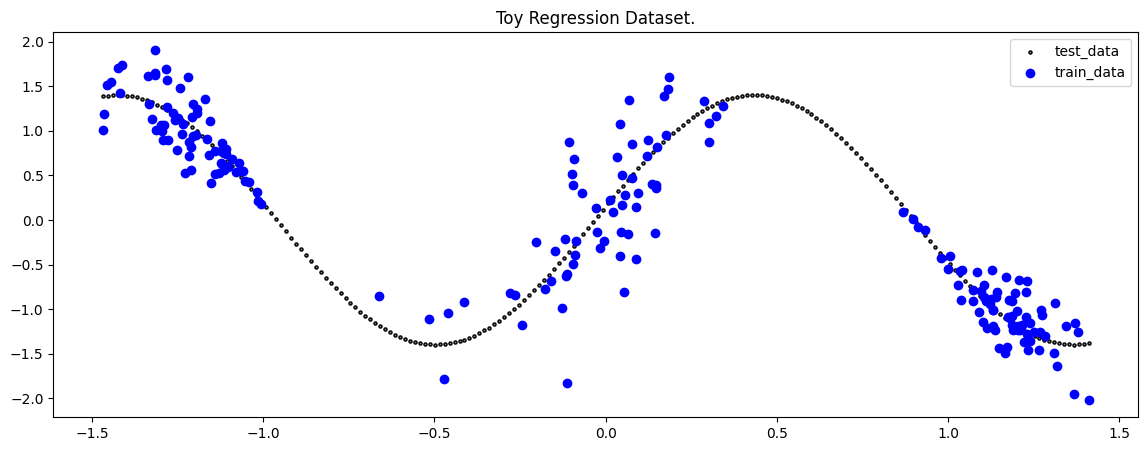

In [5]:
plot_toy_regression_data(X_train, y_train, X_test, y_test)

## Model

For our Toy Regression problem, we will use a simple Multi-layer Perceptron (MLP) that you can configure to your needs. For the documentation of the MLP see [here](https://readthedocs.io/en/stable/api/models.html#MLP).

In [6]:
quantiles = [0.1, 0.5, 0.9]
network = MLP(
    n_inputs=1, n_hidden=[50, 50, 50], n_outputs=len(quantiles), activation_fn=nn.Tanh()
)
network

MLP(
  (model): Sequential(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Tanh()
    (8): Dropout(p=0.0, inplace=False)
    (9): Linear(in_features=50, out_features=3, bias=True)
  )
)

With an underlying neural network, we can now use our desired UQ-Method as a sort of wrapper. All UQ-Methods are implemented as [LightningModule](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html), so in this case we will use the Quantile Regression Model.

In [7]:
qr_model = QuantileRegression(
    model=network, optimizer=partial(torch.optim.Adam, lr=4e-3), quantiles=quantiles
)

## Trainer

Now that we have a LightningDataModule and a UQ-Method as a LightningModule, we can conduct training with a [Lightning Trainer](https://lightning.ai/docs/pytorch/stable/common/trainer.html). It has tons of options to make your life easier, so we encourage you to check the documentation.

In [8]:
logger = CSVLogger(my_temp_dir)
trainer = Trainer(
    max_epochs=300,  # number of epochs we want to train
    logger=logger,  # log training metrics for later evaluation
    log_every_n_steps=1,
    enable_checkpointing=False,
    enable_progress_bar=False,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training our model is now easy:

In [9]:
trainer.fit(qr_model, dm)


  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MLP              | 5.4 K 
1 | loss_fn       | QuantileLoss     | 0     
2 | train_metrics | MetricCollection | 0     
3 | val_metrics   | MetricCollection | 0     
4 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
5.4 K     Trainable params
0         Non-trainable params
5.4 K     Total params
0.021     Total estimated model params size (MB)
/home/nils/.virtualenvs/uqboxEnv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/nils/.virtualenvs/uqboxEnv/lib/python3.9/site-packages/lightning/pytorch/t

`Trainer.fit` stopped: `max_epochs=300` reached.


## Training Metrics

To get some insights into how the training went, we can use the utility function to plot the training loss and RMSE metric.

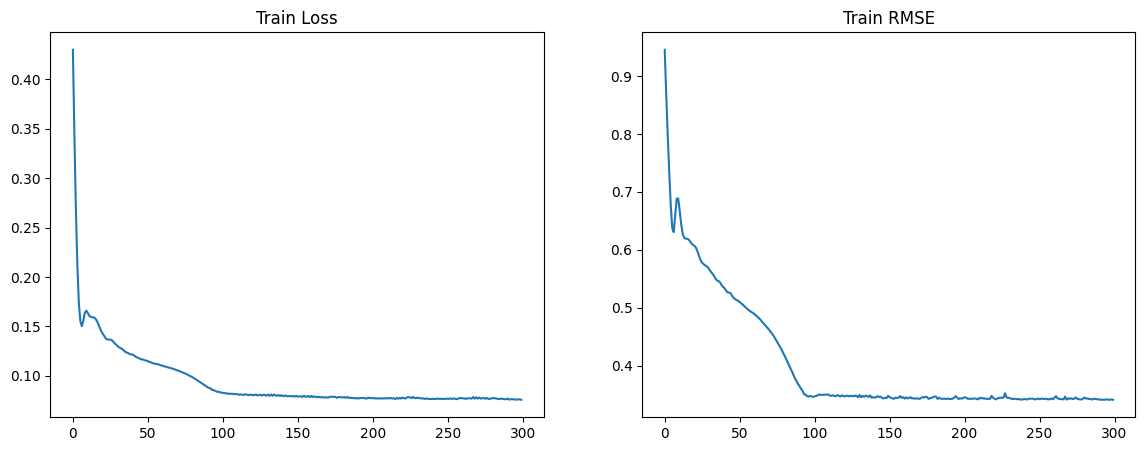

In [10]:
fig = plot_training_metrics(os.path.join(my_temp_dir, "lightning_logs"), "RMSE")

## Predictions without the Conformal Procedure

In [11]:
qr_preds = qr_model.predict_step(X_test)

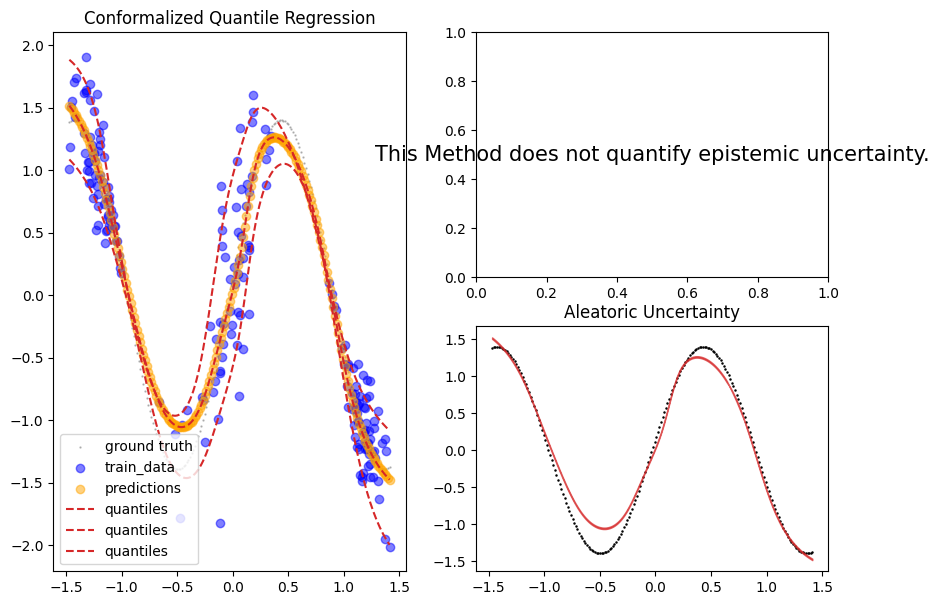

In [12]:
fig = plot_predictions_regression(
    X_train,
    y_train,
    X_test,
    y_test,
    qr_preds["pred"],
    pred_quantiles=np.stack(
        [qr_preds["lower_quant"], qr_preds["pred"].squeeze(), qr_preds["upper_quant"]],
        axis=-1,
    ),
    aleatoric=qr_preds["aleatoric_uct"],
    title="Conformalized Quantile Regression",
)

<Figure size 1400x500 with 0 Axes>

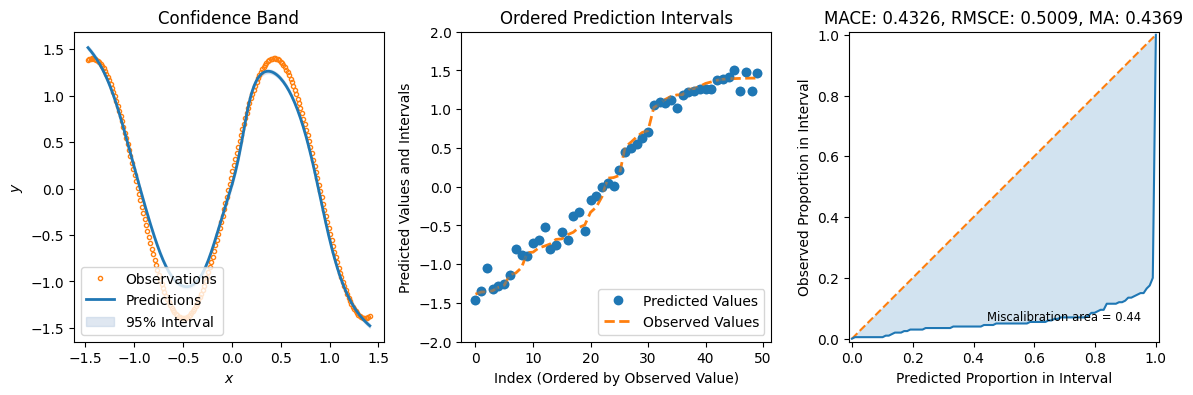

In [13]:
fig = plot_calibration_uq_toolbox(
    qr_preds["pred"].cpu().numpy(),
    qr_preds["pred_uct"],
    y_test.cpu().numpy(),
    X_test.cpu().numpy(),
)

## Conformal Prediction

As a calibration procedure we will apply Conformal Prediction now. The method is implemented in a LightningModule that will compute the $\hat{q}$ value to adjust the quantile bands for subsequent predictions

In [14]:
conformal_qr = ConformalQR(qr_model, quantiles=quantiles)

In the next step we are leveraging existing lightning functionality, by casting the post-hoc fitting procedure to obtain q_hat during a "validation" procedure. 

In [15]:
trainer = Trainer(enable_checkpointing=False, enable_progress_bar=False)
trainer.validate(conformal_qr, dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/nils/.virtualenvs/uqboxEnv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


[{}]

Now we can make predictions for any new data points we are interested in or get conformalized predictions for the entire test set.

In [16]:
trainer.test(conformal_qr, dm)
cqr_preds = conformal_qr.predict_step(X_test)

/home/nils/.virtualenvs/uqboxEnv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


## Evaluate Predictions

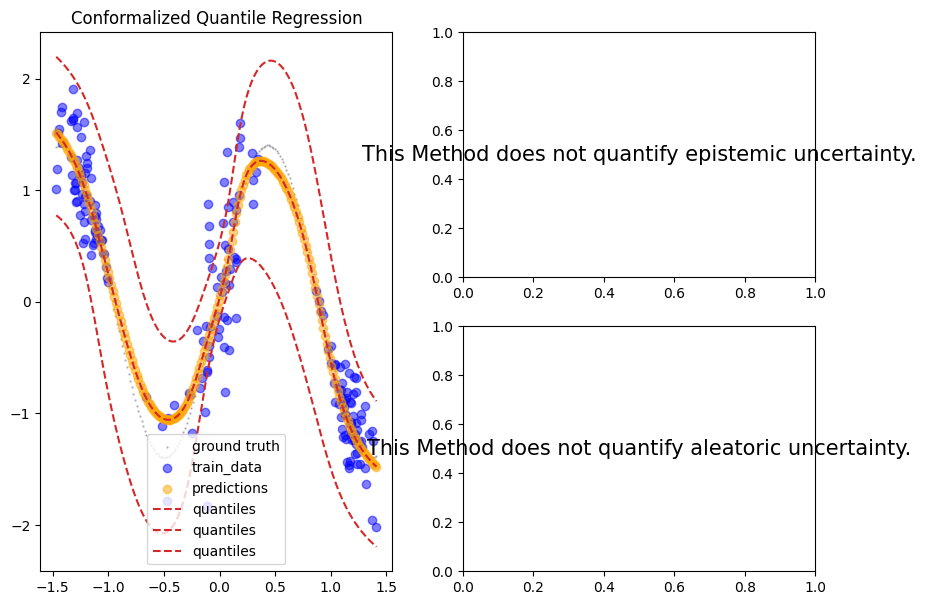

In [17]:
fig = plot_predictions_regression(
    X_train,
    y_train,
    X_test,
    y_test,
    cqr_preds["pred"],
    pred_quantiles=np.stack(
        [
            cqr_preds["lower_quant"],
            cqr_preds["pred"].squeeze(),
            cqr_preds["upper_quant"],
        ],
        axis=-1,
    ),
    title="Conformalized Quantile Regression",
)

In [18]:
fig = plot_calibration_uq_toolbox(
    cqr_preds["pred"], cqr_preds["pred_uct"], y_test.cpu().numpy(), X_test.cpu().numpy()
)

KeyError: 'pred_uct'